Import all the relevant stuff

In [1]:
# eeg analysis libraries
import mne

# import plotting libraries
from matplotlib import pyplot as plt
import seaborn as sns
from plotnine import *

# numerical libraries
import numpy as np
import pandas as pd

# import tqdm for a progress bar:
try:
    from tqdm import tqdm_notebook as tqdm
except:
    from tqdm import tqdm

# import file path operators
from pathlib import Path
import os

# avoid MNE being too verbose
mne.set_log_level('ERROR')

//anaconda/envs/py36/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


List all files

In [38]:
from Data import raws, events

for raw in raws():
    print(raw.info['subject_info'])

{'pid': '0001', 'group': 'CTR'}
{'pid': '0025', 'group': 'CTR'}


Run preprocessing

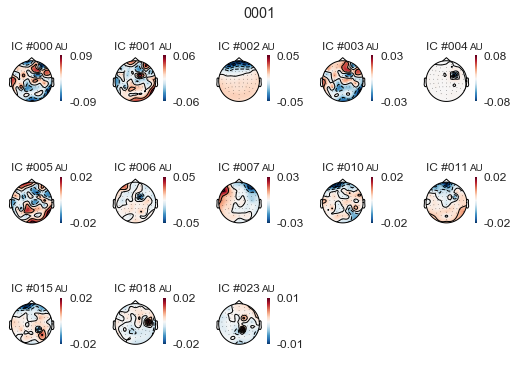

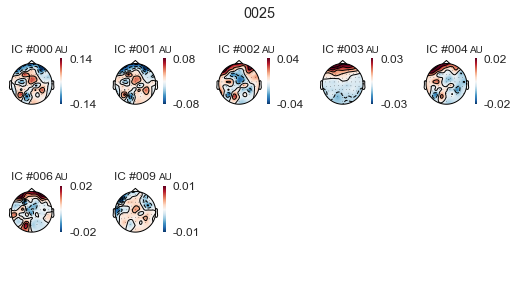

In [46]:
for raw, event in zip(raws(), events()):


    # load the raw data
    raw = raw.load_data()
    subid = (raw.info['subject_info']['pid'])
    
    # create a new virtual channel for the VEOG and HEOG
    veog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG3', 'EXG4']), :]
    veog = np.diff(veog, axis=0)
    heog, _ = raw[mne.pick_channels(raw.ch_names, include=['EXG1', 'EXG2']), :]
    heog = np.diff(heog, axis=0)
    
    new_info = mne.create_info(['VEOG', 'HEOG'], 1024, ch_types='eog')
    raw.info['lowpass'] = new_info['lowpass'] = 1024
    
    # add these two new channels to the data
    raw = raw.add_channels(
        [mne.io.RawArray(np.concatenate([veog, heog], axis=0), new_info)]
    )
    
    # drop extra channels (not used)
    raw = raw.drop_channels(['EXG7', 'EXG8'])
    # resample the data (w/ parallel processing)
    raw = raw.resample(512, n_jobs = 6)


    # set the average of the mastoids as reference
    raw = raw.set_eeg_reference()
    raw = raw.apply_proj()
        
    # filter the EOG data
    raw = raw.filter(0.5, 15, picks=mne.pick_types(raw.info, eeg=False, eog=True), n_jobs=6)
    # filter the EEG data (bandstop for mains and all harmonics)
    raw = raw.notch_filter(np.arange(50, raw.info['lowpass'], 50), n_jobs=6)
    # high-pass filter the data
    raw = raw.filter(0.5, 45)
    
    # run an ICA to remove components correlated with both horizontal and vertical EOG traces
    seed = np.random.RandomState(2017)
    
    ica = mne.preprocessing.run_ica(raw, n_components=0.99, max_pca_components=64,
                                    random_state=seed, eog_ch=['HEOG', 'VEOG'],
                                    picks=mne.pick_types(raw.info, eeg=True))
    
    # plot the components to be excluded:
    ica.plot_components(picks=ica.exclude, title=subid, colorbar=True)
    
    # apply the ICA correction:
    raw = ica.apply(raw)
    
    # epoch the data to include only eyes closed:
    epochs = mne.Epochs(raw, event, event_id={'eyes closed': 102}, tmin=0, tmax=55, preload=True)
    # remove the first 5 seconds
    epochs = epochs.crop(tmin=5)
    
    # perform the connectivity analysis:
    conn = mne.connectivity.spectral_connectivity(epochs, method='wpli',
                                                  mode='multitaper', fmin=1, fmax=40, 
                                                  faverage=True, n_jobs=2)
    
    # save individual arrays of each subject (there is probably a better way than to go via numpy to pandas to save this...)
    output = np.asarray(conn)
    df = pd.DataFrame(output)
    savename = ('./Output/'+subid+'_conn.csv')
    df.to_csv(savename)
    


In [47]:
dir(conn)

['__add__', '__class__', '__contains__', '__delattr__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__getnewargs__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__mul__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__rmul__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', 'count', 'index']